In [6]:
import control
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import math
from sortedcontainers import SortedDict

plt.style.use('dark_background')

In [7]:
Mmotor = 0.600 # 0.086
Mfly = 0.1 # 0.0357 * 183.594 / 280.698
rdisk = 0.0617318752905765
La = 0.20
Ifly = (rdisk - 1E-2) ** 2 * (10 * 5.6E-3) + 69.446E-6 # 4.85E-5 * 3.707 / 5.370 # Mfly * rdisk ** 2 / 2
Ifly_ctr = Ifly + Mfly * La ** 2
Itot = (1.612E+07 * 1E-9) + Ifly_ctr # (Ifly_ctr + Mmotor * La) # nah never mind # * 2 # I _think_ it's x2 because in the inertial frame the Earth is the other part of that arm
Mtot = Mmotor + Mfly
g = 9.8
b = 0.154 # accel per rad/s

# vars: theta, theta', fly_v
# input: flywheel acceleration (rad/s^2)
A = np.array([[ 0, 1, 0 ], [ Mtot * La / 2 * g / Itot, 0, b * Ifly / Itot ], [ 0, 0, -b ]])
B = np.array([ 0, -Ifly / Itot, 1 ]).reshape((-1, 1))
Q = np.diag([ 0.1, 0.001, 50 ])
R = np.array([ 100 ])

In [28]:
RAD_PER_TILT = 0.2 / 512 # rad per tilt LSB
GYRO_GAIN = (2000 * math.pi / 180) / (2 ** 15) # rad/s per gyro LSB
CTRL_T = 0.0008 # control loop nominal tick period
RAD_PER_TICK = math.pi * 2 / 42 # radians per flywheel hall tick
TICK_T = 1E-6 # flywheel tick nominal period
L = [
    RAD_PER_TILT, # rad / tilt LSB
    GYRO_GAIN, # rad/s / gyro LSB
    1.0, # rad/s / speed_avg
]
K = control.lqr(A, B, Q, R)[0]
# K = np.array(list(np.array(K)[0]) + [0]).reshape((1,-1)) # pad by 1
print(K)
# print(K * 3.1E-4)
print(np.array(K) * L)
# [[-0.42929117 -0.90733222 -0.49847872]]

[[-7.03546607e+03 -1.21143174e+03 -8.77682317e-01]]
[[-2.74822893 -1.29049515 -0.87768232]]


In [25]:
Ki = 117.1
F0 = 113.1
VDD = 7.6
T0 = (VDD * Ki - F0) * Ifly # 0.6
Kv = 160.10
Kv0 = -46.45
Vmax = Kv * VDD - Kv0 # VDD * KV / 60 * math.pi * 2

In [10]:
# theoretical performance of JD-Power [lol] sensored gimbal motors
Ki = (0.19 / 12.0) / Ifly # rad/s^2/V
F0 = 50 # just assume half the friction or something
VDD = 11.1
T0 = (VDD * Ki - F0) * Ifly # 0.6
Kv = 7.1 # rad/s/V
Kv0 = -2 # assume about the same ratio as the outrunner BLDC (although probably a bit better)
Vmax = Kv * VDD - Kv0 # VDD * KV / 60 * math.pi * 2

In [26]:
sigma = 0.1
sigma_v = T0 / Itot / 10
T = np.arange(0, 3, 0.05)
N = np.random.normal(scale=1, size=(2,) + T.shape) * [[sigma], [sigma_v]]
Aprime = A - np.dot(B, K)
SS = control.StateSpace(Aprime, np.array([[1, 0, 0], [ 0, 1, 0 ]]).T, np.eye(A.shape[0]), np.zeros((A.shape[1], 2)))
X0 = (0.1, 0.3, 0)
Tout, _, xout = control.forced_response(SS, T, N, X0=X0)
xdot = np.dot(Aprime, xout)

Text(0, 0.5, 'Torque (N-m)')

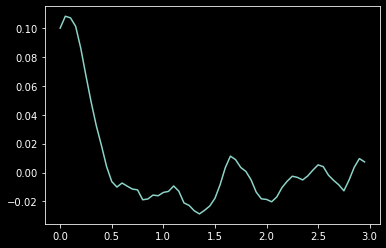

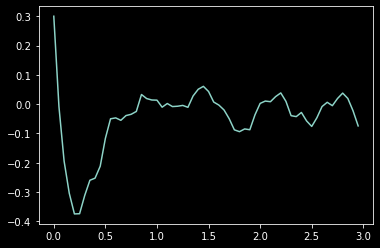

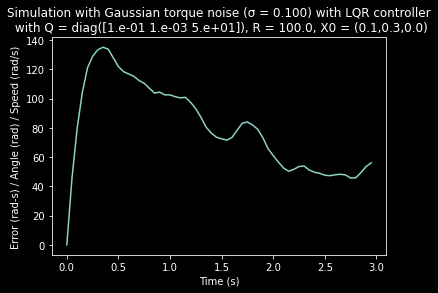

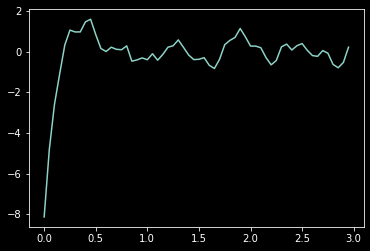

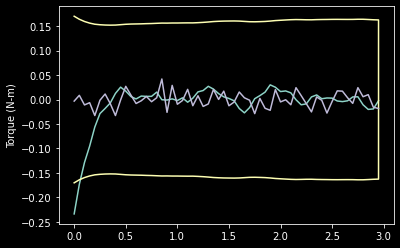

In [27]:
[plt.figure() and plt.plot(Tout, x) for x in xout]
plt.xlabel('Time (s)')
plt.ylabel('Error (rad-s) / Angle (rad) / Speed (rad/s)')
plt.title('Simulation with Gaussian torque noise (σ = %.3f) with LQR controller\n with Q = diag(%s), R = %.1f, X0 = (%s)' % (sigma, str(np.diag(Q)), R, ",".join(["%.1f" % x for x in X0])))
plt.figure()
plt.plot(Tout, np.array(xdot)[1])
plt.figure()
plt.plot(Tout, np.dot(np.array(K), xout).squeeze() * Ifly)
Tmax = T0 * (1 - xout[2,:] / Vmax)
plt.plot(np.hstack((Tout, Tout[::-1])), np.hstack((Tmax, -Tmax[::-1])))
plt.plot(T, N[1,:] * Itot)
plt.ylabel('Torque (N-m)')
# plt.plot(Tout, -(1 - abs(xout[2]) / Vmax) * T0, 'tab:purple')
# plt.plot(Tout, (1 - abs(xout[2]) / Vmax) * T0, 'tab:purple')
# plt.legend(['Fly speed (rad/s)', 'Fly accel (rad/s^2)']) # , 'Flywheel speed (rad/s)', 'Control torque (N-m)'])